In [11]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O_reactions.inp'

# import libraries:
import importlib   # For reloading your own files
import numpy as np
# my own files:
import Bubble_dynamics_simulation.inp_data_extractor as inp   # numeric constants and coefficents
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

Note, lambda value for specie 'NO' is not in data.py: 0.0 is used
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'O' is not in data.py: 0.0 is used
Note, lambda value for specie 'OH' is not in data.py: 0.0 is used
Note, lambda value for specie 'HO2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2OH' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NO' is not in data.py: 0.0 is used
Note, lambda value for specie 'HNOH' is not in data.py: 0.0 is used
Note, lambda value for specie 'HNO' is not in data.py: 0.0 is used
Note, lambda value for specie 'HON' is not in data.py: 0.0 is used
Note, lambda value for specie 'HONO' is not in data.py: 0.0 is used

In [4]:
"""Import simulation"""

import numpy as np
import importlib
import Bubble_dynamics_simulation.full_bubble_model as de
importlib.reload(de)

model: D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O_reactions
enable heat transfer: True	enable evaporation: False	enable reactions: True
model: D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O_reactions
enable heat transfer: True	enable evaporation: False	enable reactions: True


<module 'Bubble_dynamics_simulation.full_bubble_model' from 'd:\\parameter_studies\\Bubble_dynamics_simulation\\full_bubble_model.py'>

In [7]:
"""Control parameters"""

cpar = de.dotdict(dict(
    ID=0,
    R_E=10.0e-6, # [m]
    ratio=5.5, # [-]
    P_amb=1.01325e5, # [Pa]
    alfa_M=0.35, # [-]
    T_inf= 293.15, # [K]  #5000.0,
    surfactant=1.0, # [-]
    gases=[par.index['H2'], par.index['N2']], # indexes of species in initial bubble
    fractions=[0.75, 0.25], # molar fractions of species in initial bubble
    P_v = 2338.1, # [Pa]
    mu_L = 0.001, # [Pa*s]
    freq1=2.0e4,                          # [Hz]
    freq2=1.0e5,                          # [Hz]
    pA1=0.0e5,                            # [Pa]
    pA2=0.0e5,                            # [Pa]
    theta_phase=0.1,                      # [rad]
    c_L=1483.0,                           # [m/s]
))

succecfully solved with LSODA solver


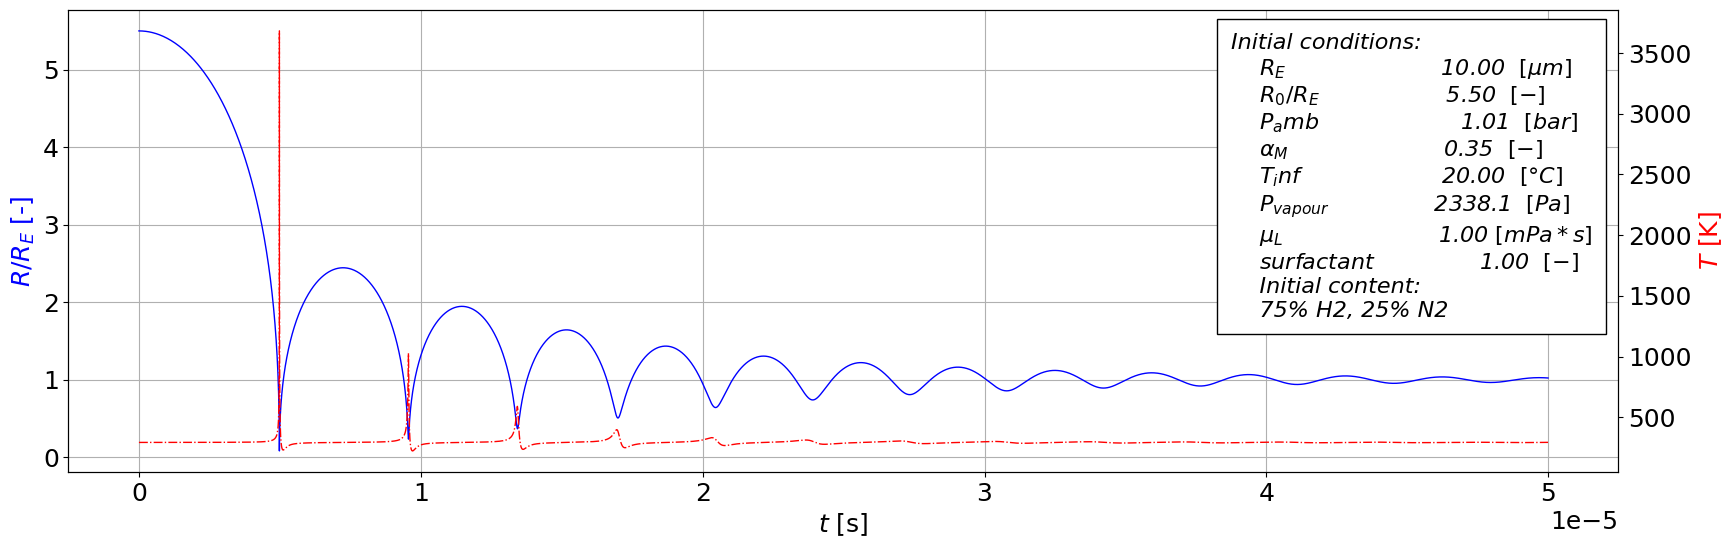

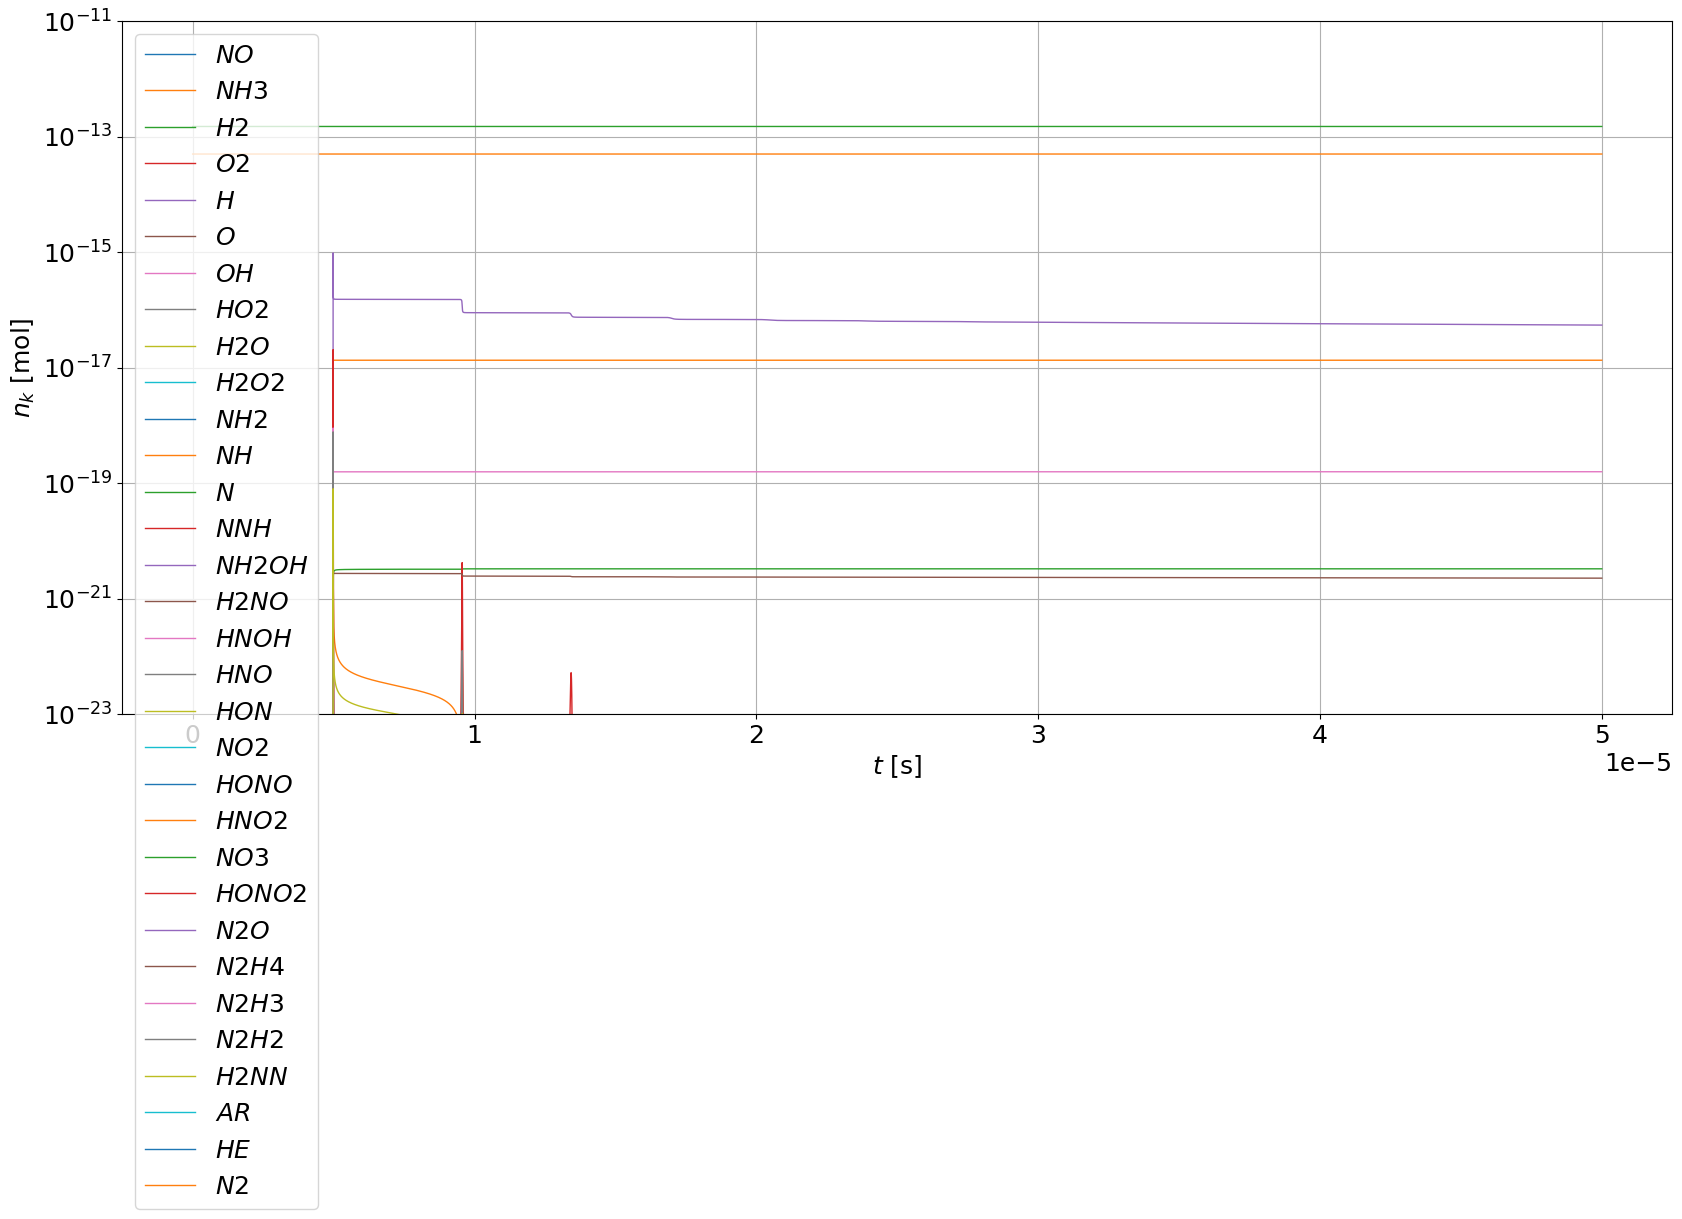

Control parameters:
    ID = 0
    R_E = 10.00 [um]
    ratio = 5.50 [-]
    P_amb = 1.01 [bar]
    alfa_M = 0.35 [-]
    T_inf = 20.00 [°C]
    P_v = 2338.10 [Pa]
    mu_L = 1.00 [mPa*s]
    surfactant = 1.00 [-]    
    freq1 = 20000 [Hz]
    freq2 = 100000 [Hz]
    pA1 = 0 [Pa]
    pA2 = 0 [Pa]
    theta_phase= 0.10 [rad]
75% H2, 25% N2
Simulation info:
    error_code = 0
    elapsed_time = 3.03 [s]
    steps = 12110 [-]
Final state:
    R_final = 10.24 [um];   R_dot_final =-0.2714848832282458 [m/s];   T_final = 293.69 [K]
    n_H2 =1.4910522175226157e-13 [mol]; n_O2 =0.0 [mol]; n_NH3=1.3362678913293461e-17 [mol];
    Final molar concentrations: [mol/cm^3]
        NO: 0.0;  NH3: 2.968334816577609e-09;  H2: 3.312166848673296e-05;  O2: 0.0;  
        H: 1.2047255842915215e-08;  O: 0.0;  OH: 0.0;  HO2: 0.0;  
        H2O: 0.0;  H2O2: 0.0;  NH2: 2.857137721326154e-26;  NH: 1.0169991770325527e-26;  
        N: 7.255199325252765e-13;  NNH: 3.747646530811239e-19;  NH2OH: 0.0;  H2NO: 0.0;  

In [10]:
"""Plotting"""

de.plot(cpar, t_int=np.array([0.0, 0.00005]))